# Analysis on Child Mortality Time Series Data

## Summary

This notebook present an analysis on child mortality data gathered by [Gapminder](https://www.gapminder.org/). The dataset contains combined data from multiple sources on the Child mortality under age 5, for all countries for all years between 1800 to 2015 for multiple countries around the world.

The indicator shown as the "Child Mortality under age 5" is the the probability that a child born in a specific year will die before reaching the age of five if subject to current age-specific mortality rates. Expressed as a rate per 1,000 live births.	 

The following analysis combines two different unsupervised methods such as Principal Component Analysis (PCA) and K-mean Clustering to be able find hidden relationships in the dataset. 

* The PCA analysis reduces the dimentionality of the data (which is represented by the yearly data features) by finding the principal components that carry most of the variance in the data, it simplifies the complexity in high-dimensional data while retaining trends and patterns.
* A K-means clustering algorithm groups toguether the countries that share similar trends in their time series data. Projecting the different clusters on the principal component space allows a better understanding of what these clusters represent.

The child mortality rate is found to be related with a country's income. However its found shown that many low income countries did a remarkable job of reducing it between in the last decades. Based on this, this study will link the GDP per capita data in 2015 (also obtained from Gapminder) with the clusters assinged to each country. From this, it might be possible to see if the clusters show discrimination between the country's income and their success of reducing the child mortality rate.


## Preparing the data

In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sb  
import random
from sklearn import preprocessing

%matplotlib inline

In [2]:
#loading the under 5 child mortality data into a pandas dataframe
file_path = 'data/gapminder_under5mortality.csv'
child_mortality_df = pd.read_csv(file_path, index_col = 0)
child_mortality_df.index.names = ['country']
child_mortality_df.shape

(440, 216)

There are 440 countries in the dataset, and for each country 215 features corresponding to the data from each year from 1800 to 2015. 

In [3]:
child_mortality_df.head()

,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
country,,,,,,,,,,,,,,,,,,,,,
Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,468.58,468.58,468.58,468.58,468.58,468.58,469.98,469.98,469.98,469.98,...,116.3,113.2,110.4,107.6,105.0,102.3,99.5,96.7,93.9,91.1
Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,...,19.5,18.7,17.9,17.3,16.6,16.0,15.5,14.9,14.4,14.0
Algeria,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,...,32.1,30.7,29.5,28.4,27.4,26.6,25.8,25.2,24.6,24.0


### Data Cleaning

There are several countries with missing or no information. These countries will be removed from the analysis in order to have a clean sample.

In [4]:
# droping rows that cointain NaN
child_mortality_clean = child_mortality_df.dropna()
child_mortality_clean.shape

(184, 216)

In [5]:
child_mortality_clean.head()

,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,468.58,468.58,468.58,468.58,468.58,468.58,469.98,469.98,469.98,469.98,...,116.3,113.2,110.4,107.6,105.0,102.3,99.5,96.7,93.9,91.1
Albania,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,...,19.5,18.7,17.9,17.3,16.6,16.0,15.5,14.9,14.4,14.0
Algeria,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,...,32.1,30.7,29.5,28.4,27.4,26.6,25.8,25.2,24.6,24.0
Angola,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,...,200.5,196.4,192.0,187.3,182.5,177.3,172.2,167.1,162.2,156.9
Antigua and Barbuda,473.60,469.77,465.97,462.20,458.47,454.76,451.08,447.43,443.82,440.23,...,11.8,11.3,10.9,10.4,9.9,9.5,9.1,8.7,8.4,8.1


From 440 countries originally in the dataset, the analysis is going to be based on 184 countries where all information is avalaible.

# Data visualisation 

The dataset contains time series data for 184 different countries. Lets visualise the time series for a number of countries (the countries shown in the figure are randomly chosen). 

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

In [7]:
def plot_timeseries_df(df,linewidth=5):
    '''Function created a time series visualisation for 
    a number of countries given as input in a dataframe'''
    
    if 'cluster' in df.columns:
        df = df.drop('cluster',axis=1)
    
    df = df.T
    df.index = pd.to_datetime(df.index.values, format='%Y')    
    ax = df.plot(figsize=(16,8), linewidth=linewidth, fontsize=20)
    ax.set_xlabel("Year", fontsize=20)
    ax.set_ylabel("Under 5 child mortality", fontsize=20)
    ax.legend(bbox_to_anchor=(1.1, 1.05))

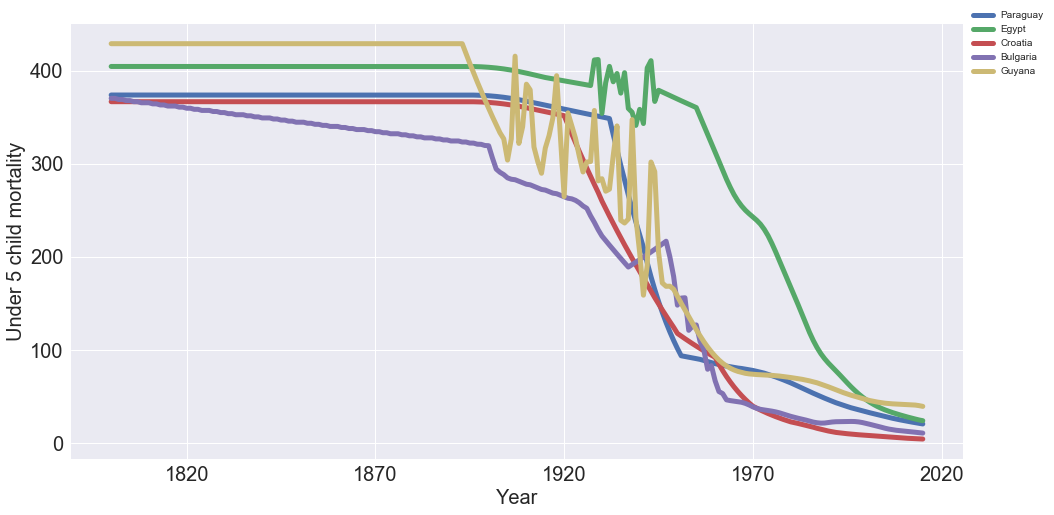

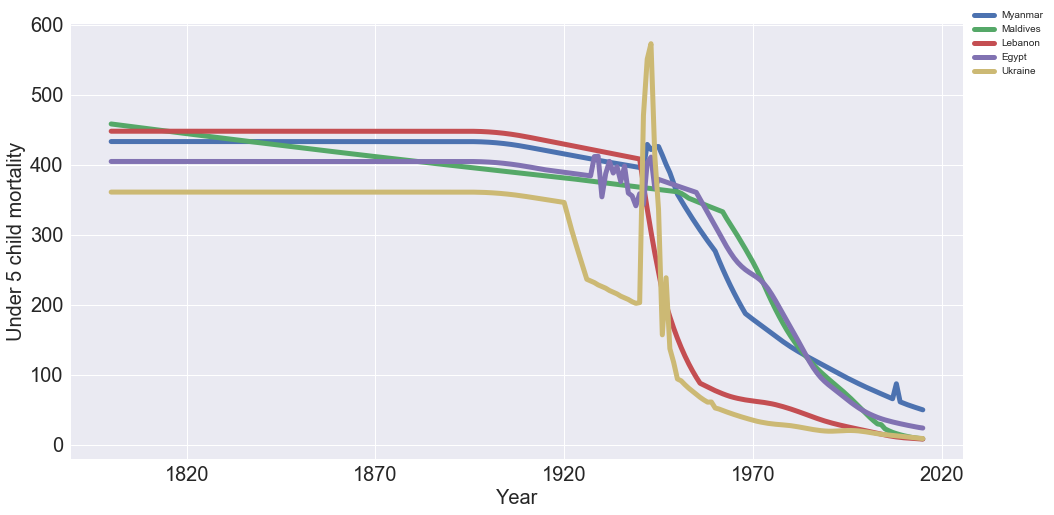

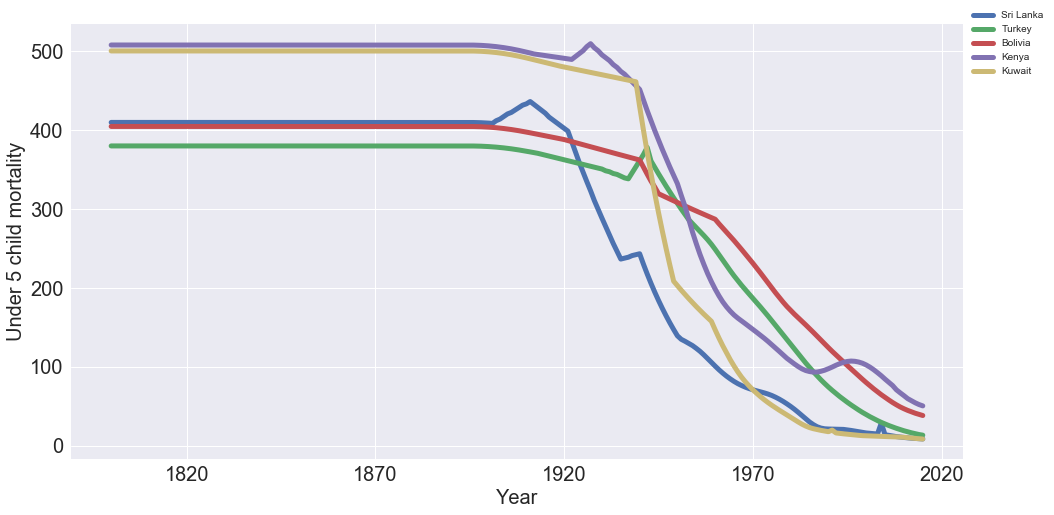

In [8]:
plot_timeseries_df(child_mortality_clean.sample(n=5))
plot_timeseries_df(child_mortality_clean.sample(n=5))
plot_timeseries_df(child_mortality_clean.sample(n=5))

The figures show that all countries have a general reduction in the "Under 5 child mortality" metric as a function of the time. However the behaivour (slope, volatility, bumpiness) of that decrease can be very different from country to country.

# Principal Component Analysis on the time series data

Each row in the child mortality dataframe is a country represented by 215 different variables, which correspond to the "Under 5 child mortality" value for a given year from 1800 to 2015. These variables represent not just the total value or average of the metric in the time range but also all the variations in the time series and relationships within countries in a given year. By perfoming a dimensionality reduction with PCA it is possible to reduce those 215 variables to just a few, that best capture the trends in the data. 

## Scaling the data

Before applying PCA if is important to normalise the data, in order to have all the data point on the same scale. This is done to assuere that no extra weight is given to the “larger” value variables regarding the “smaller” ones which otherwise might lead to biased outcomes.

In [9]:
#scaler from sklearn
scaler = preprocessing.MinMaxScaler()
scaled_df = scaler.fit_transform(child_mortality_clean)
scaled_child_mortality_df = pd.DataFrame(scaled_df, columns =child_mortality_clean.columns, index =child_mortality_clean.index  )

In [10]:
#show scaled data
scaled_child_mortality_df.head()

,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.670427,0.670427,0.720965,0.728932,0.732634,0.738263,0.695571,0.731171,0.686761,0.707986,...,0.573887,0.570248,0.568938,0.568723,0.497093,0.571429,0.572604,0.573592,0.573658,0.575484
Albania,0.242157,0.242157,0.358366,0.376688,0.385199,0.398142,0.286066,0.369554,0.265404,0.315181,...,0.084008,0.082128,0.080296,0.080087,0.068798,0.078286,0.078777,0.078134,0.077403,0.078065
Algeria,0.632040,0.632040,0.688463,0.697359,0.701492,0.707776,0.653359,0.693895,0.643327,0.667496,...,0.147773,0.144112,0.141574,0.140152,0.121124,0.138857,0.139330,0.140521,0.141074,0.142581
Angola,0.748853,0.748853,0.787365,0.793436,0.796257,0.800546,0.763405,0.791072,0.756557,0.773053,...,1.000000,1.000000,1.000000,1.000000,0.872578,1.000000,1.000000,1.000000,1.000000,1.000000
Antigua and Barbuda,0.693451,0.675885,0.710830,0.704866,0.695018,0.687926,0.613912,0.645135,0.570463,0.584691,...,0.045040,0.043905,0.043317,0.042749,0.036337,0.041143,0.041152,0.040581,0.039950,0.040000


# Implemented PCA

Once the data is properly scale, it is time to obtain the principal components that contain most of the variance in the data. The sklearn library is used to estimate 4 principal components, that should contain 95% of the variance.

In [11]:
from  sklearn.decomposition  import PCA
# define the number of components and fit into the data
pca = PCA(n_components=4)
pca.fit(scaled_child_mortality_df)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Now its time to transform the data into the 4 PCs.

In [12]:
#transform
child_mortality_4D = pca.transform(child_mortality_clean)
#print the variance in each component
print(pca.explained_variance_ratio_)

[0.7156319  0.15235747 0.04932878 0.03089097]


The 4 components carry aprox 95% of the variance from the original dataset.

In [13]:
# Convert the transformed 'child_mortality_4D' data from a numPy array to a dataframe.
child_mortality_PC_df = pd.DataFrame(child_mortality_4D, columns =['PC1','PC2','PC3','PC4'] , index = scaled_child_mortality_df.index)
child_mortality_PC_df.head()

,PC1,PC2,PC3,PC4
country,,,,
Afghanistan,5623.678400,2349.563483,370.784187,-54.758734
Albania,3647.833950,2485.348093,420.251519,221.073210
Algeria,4814.868422,2816.052301,400.497590,-0.358713
Angola,5720.312399,2274.596290,578.727988,207.860646
Antigua and Barbuda,2649.075313,2050.629896,1225.653936,-208.262380


# Visualising the data on the PC plane

The first to components carry aprox 87% of the variance. Projecting the countrys data into the PC1-PC2 plane can provide interesting relationships of the data.

Text(0,0.5,u'PC1')

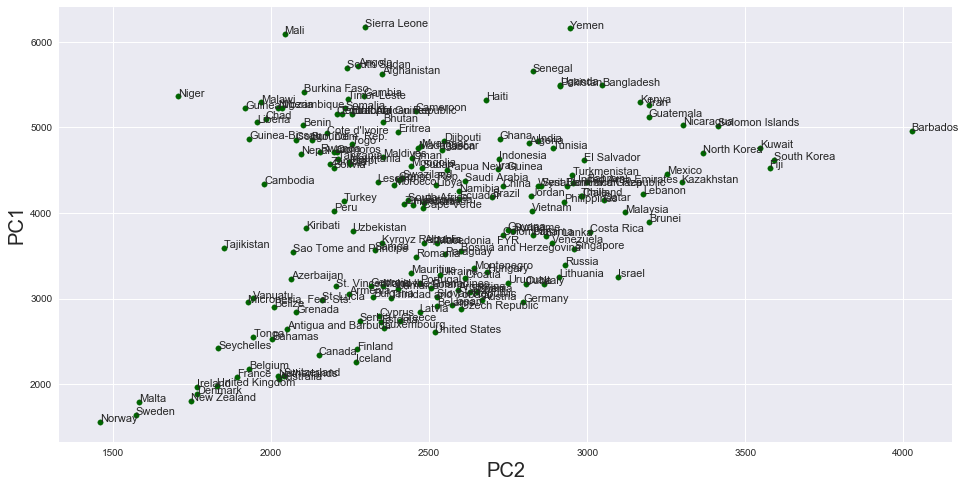

In [14]:
# compute scatter plot on PC1 and PC2
ax = child_mortality_PC_df.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8),color='DarkGreen',s = 30)

# add country names to the plot
for i, country in enumerate(child_mortality_PC_df.index):
    ax.annotate(country, (child_mortality_PC_df.iloc[i].PC2, child_mortality_PC_df.iloc[i].PC1),fontsize=11)

ax.set_xlabel('PC2', fontsize=20)
ax.set_ylabel('PC1',fontsize=20)

PC1 shows separation in countries that are notably different (Mali, Sierra Leone vs Norway, Sweden). However is not that clear what is PC2 representing. What makes South Korea significanly different to Norway? 

To understand this better, reverse engineering  is going to be applied to obtain metrics that can be related to the principal components.

# Computing new descriptive metrics

Based on the PCA and features observed in the data the following metrics are computed:
* The country average value across the time series
* The change on the "Under 5 mortality" metric between 1800 and 2015
* The starting value observed in each country (1800)
* The slope on the change of the"Under 5 mortality" metric on the 20th century (before that the metric was stable for most countries).

All these metrics are computed from the data and standarised in order to have all in the same comparable scale.

### Country average value across the time series:

In [15]:
#compute the country average value from the scaled dataset, add it to the PC dataframe
child_mortality_PC_df['country_mean_scaled'] = pd.Series(scaled_child_mortality_df.mean(axis=1), index=scaled_child_mortality_df.index)

### The change on the "Under 5 mortality" metric between 1800 and 2015


In [16]:
#compute the country change value from the unscaled datased
child_mortality_PC_df['country_change'] = pd.Series(child_mortality_clean['1800']-child_mortality_clean['2015'], index=child_mortality_clean.index)
country_change_max = child_mortality_PC_df['country_change'].max()
country_change_min = child_mortality_PC_df['country_change'].min()

#scale the value
country_change_scaled = (child_mortality_PC_df.country_change - country_change_min) / country_change_max

#add it to a the PC dataframe
child_mortality_PC_df['country_change_scaled'] = pd.Series(country_change_scaled, index=child_mortality_PC_df.index)

### The starting value observed in each country (1800)


In [17]:
child_mortality_PC_df['country_max'] = pd.Series(child_mortality_clean['1800'],index=child_mortality_clean.index)
country_mean_max = child_mortality_PC_df['country_max'].max()
country_mean_min = child_mortality_PC_df['country_max'].min()
country_mean_scaled = (child_mortality_PC_df.country_max-country_mean_min) / country_mean_max
child_mortality_PC_df['country_max_scaled'] = pd.Series(country_mean_scaled, index=child_mortality_clean.index)

### The slope on the change of the"Under 5 mortality" metric on the 20th century


In [18]:
child_mortality_PC_df['country_change_slope'] = pd.Series((child_mortality_clean['1900']-child_mortality_clean['2000'])/float(2000-1900), index=child_mortality_clean.index)
country_change_max = child_mortality_PC_df['country_change_slope'].max()
country_change_min = child_mortality_PC_df['country_change_slope'].min()
country_change_scaled = (child_mortality_PC_df.country_change_slope - country_change_min) / country_change_max
child_mortality_PC_df['country_change_slope_scaled'] = pd.Series(country_change_scaled, index=child_mortality_PC_df.index)
child_mortality_PC_df.head()

,PC1,PC2,PC3,PC4,country_mean_scaled,country_change,country_change_scaled,country_max,country_max_scaled,country_change_slope,country_change_slope_scaled
country,,,,,,,,,,,
Afghanistan,5623.678400,2349.563483,370.784187,-54.758734,0.735693,377.48,0.168827,468.58,0.270483,3.4477,0.379062
Albania,3647.833950,2485.348093,420.251519,221.073210,0.385736,361.20,0.136258,375.20,0.097698,3.4819,0.384311
Algeria,4814.868422,2816.052301,400.497590,-0.358713,0.590964,436.21,0.286320,460.21,0.254996,4.1951,0.493776
Angola,5720.312399,2274.596290,578.727988,207.860646,0.780208,328.78,0.071400,485.68,0.302124,2.6793,0.261124
Antigua and Barbuda,2649.075313,2050.629896,1225.653936,-208.262380,0.255192,465.50,0.344917,473.60,0.279772,1.9478,0.148850


## Visualise the relationships between the PC transformed data and the new variables

In the following pairplot is possible to observe high correlations between some of the new metrics and the principal component transformed data.

Particularly the highest correlations are on the 'country_mean_scaled' variable and PC1 as well as 'country change slope' and PC2.

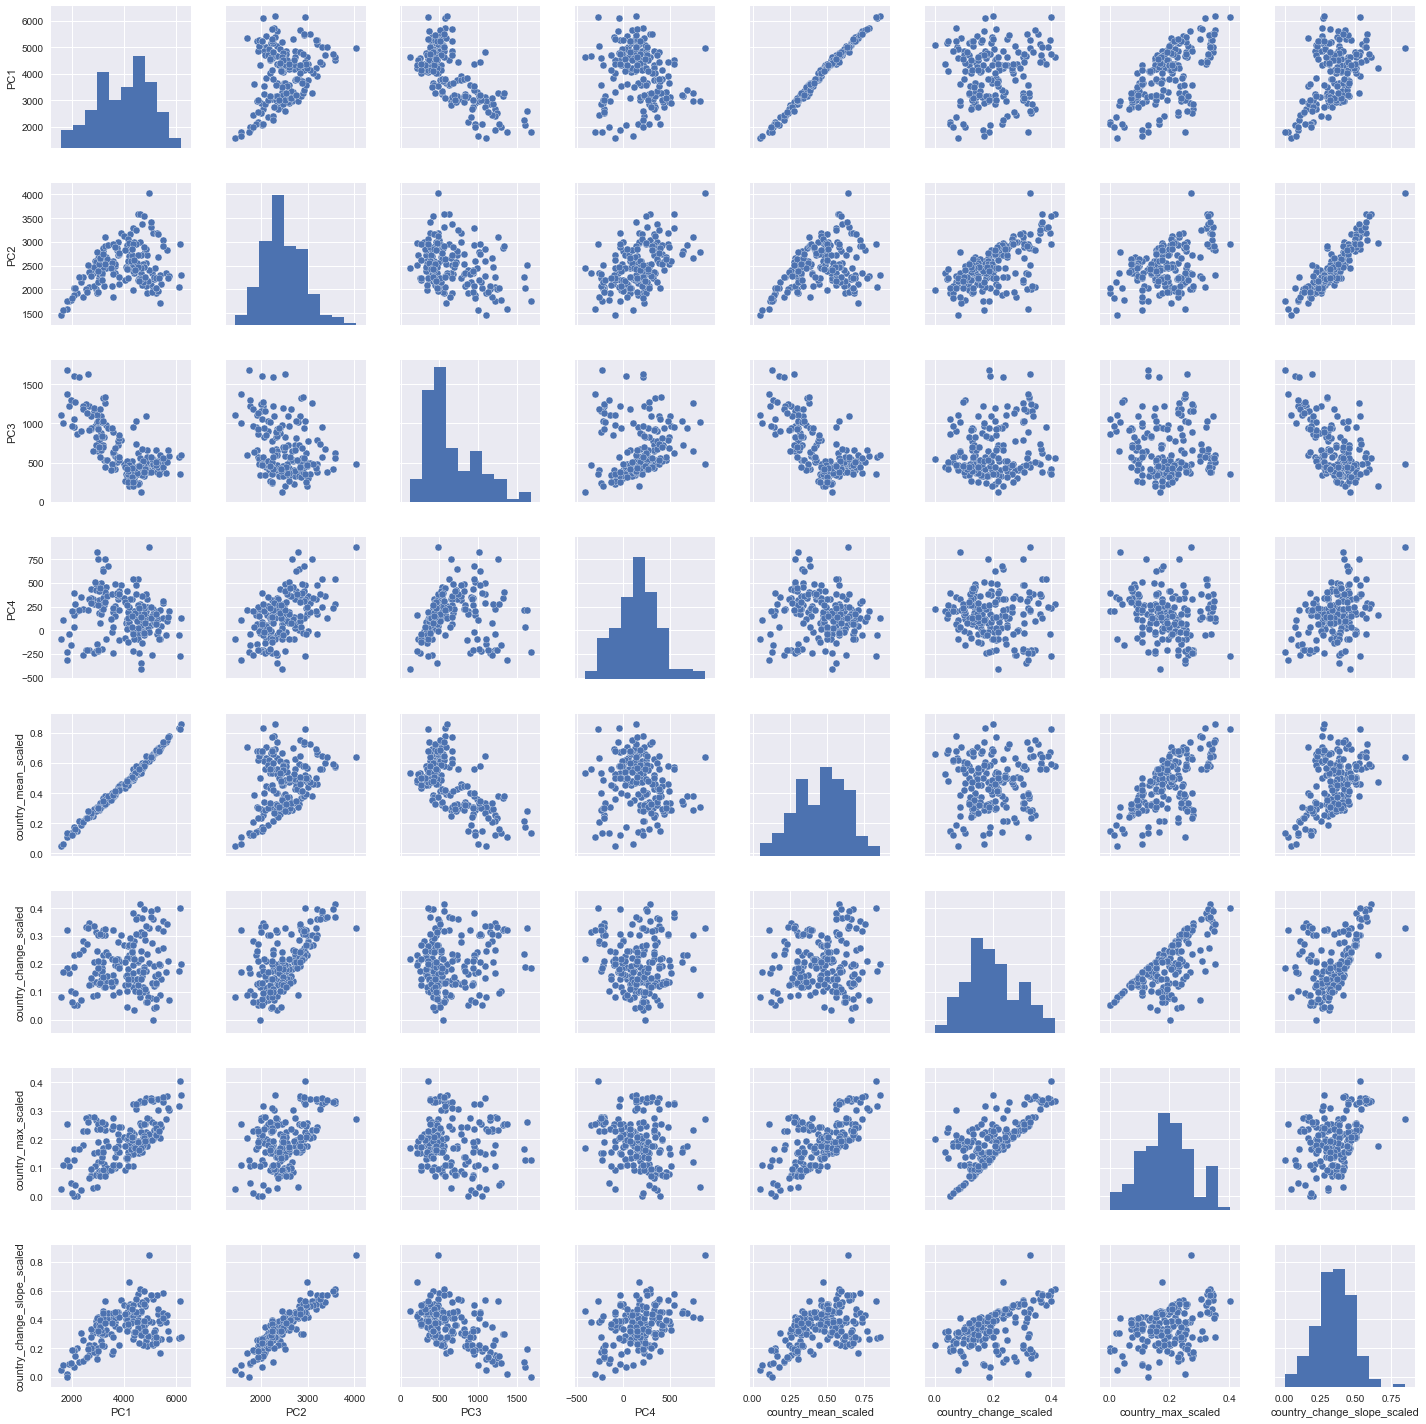

In [19]:
seaborn.pairplot(child_mortality_PC_df[['PC1','PC2','PC3','PC4','country_mean_scaled','country_change_scaled'
                                        ,'country_max_scaled','country_change_slope_scaled']])

Knowing the variables most correlated with the PC projections it is interesting to revisit the 2D figures of the countries in the PC1-PC2 plane, weighted by their value in these variables. 

Text(0,0.5,u'PC1')

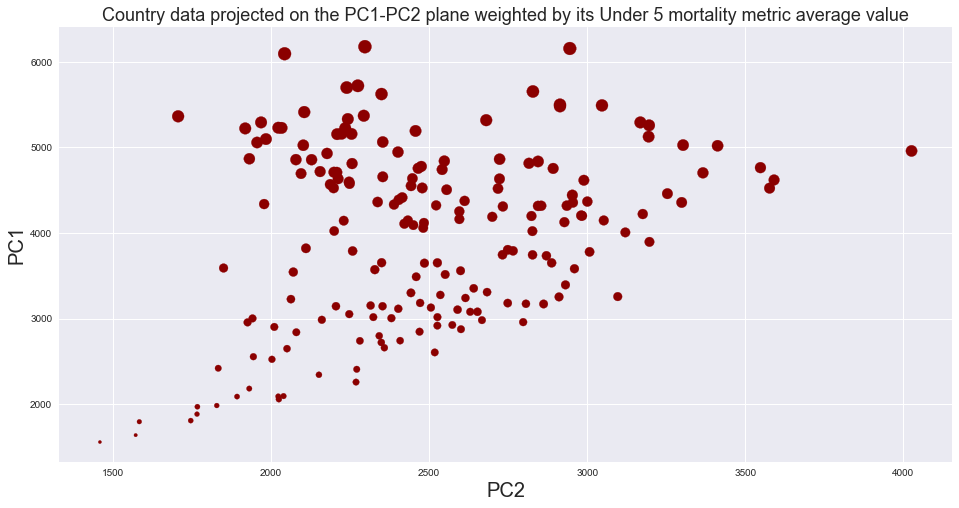

In [20]:
ax = child_mortality_PC_df.plot(kind='scatter', x='PC2', y='PC1', 
                                s=child_mortality_PC_df['country_mean_scaled']*200, figsize=(16,8),color='DarkRed')
ax.set_title('Country data projected on the PC1-PC2 plane weighted by '
             'its Under 5 mortality metric average value', fontsize=18)
ax.set_xlabel('PC2', fontsize=20)
ax.set_ylabel('PC1',fontsize=20)

Text(0,0.5,u'PC1')

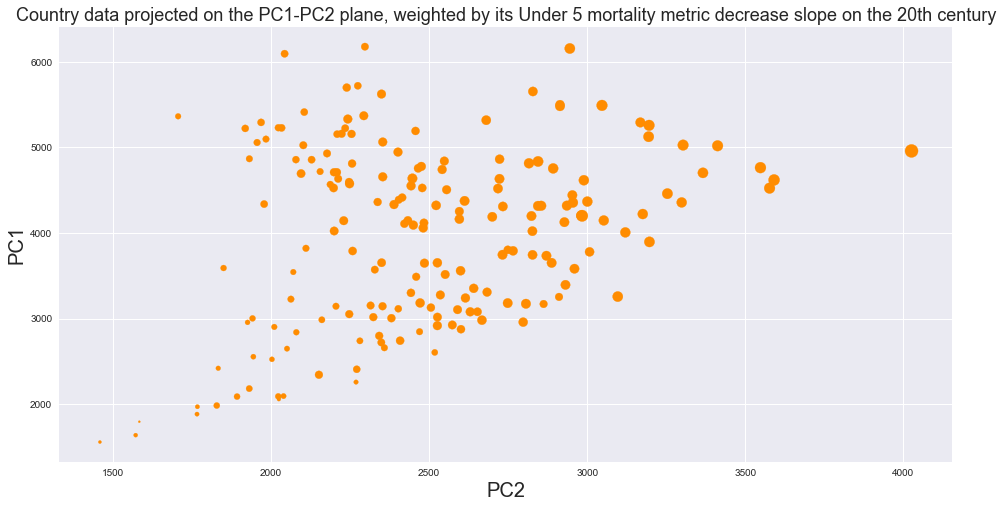

In [21]:
ax = child_mortality_PC_df.plot(kind='scatter', x='PC2', y='PC1', 
                                s=child_mortality_PC_df['country_change_slope_scaled']*200, figsize=(16,8),color='DarkOrange')
ax.set_title('Country data projected on the PC1-PC2 plane, weighted by '
             'its Under 5 mortality metric decrease slope on the 20th century', fontsize=18)
ax.set_xlabel('PC2', fontsize=20)
ax.set_ylabel('PC1',fontsize=20)

### Correlations between the PC variables and the new metrics

In [22]:
from scipy.stats.stats import pearsonr   

child_mortality_PC_df[['PC1','PC2','PC3','PC4','country_mean_scaled','country_max_scaled','country_change_scaled','country_change_slope_scaled']].corr()

,PC1,PC2,PC3,PC4,country_mean_scaled,country_max_scaled,country_change_scaled,country_change_slope_scaled
PC1,1.000000,0.310826,-0.725560,-0.120646,0.995618,0.627788,0.103868,0.486091
PC2,0.310826,1.000000,-0.283485,0.495487,0.317721,0.421108,0.609510,0.906256
PC3,-0.725560,-0.283485,1.000000,0.118333,-0.661045,-0.104391,0.159916,-0.560657
PC4,-0.120646,0.495487,0.118333,1.000000,-0.092797,-0.187557,-0.072385,0.377480
country_mean_scaled,0.995618,0.317721,-0.661045,-0.092797,1.000000,0.671227,0.133417,0.467564
country_max_scaled,0.627788,0.421108,-0.104391,-0.187557,0.671227,1.000000,0.724580,0.353110
country_change_scaled,0.103868,0.609510,0.159916,-0.072385,0.133417,0.724580,1.000000,0.454809
country_change_slope_scaled,0.486091,0.906256,-0.560657,0.377480,0.467564,0.353110,0.454809,1.000000


## Summary of PCA results 

FILL THIS

# Using K-means clustering to explore structures in the country data



In [23]:
from  sklearn.cluster import KMeans

scaled = scaler.fit_transform(child_mortality_clean)
scaled_df_forClustering = pd.DataFrame(scaled, columns =child_mortality_clean.columns, index =child_mortality_clean.index  )

kmeans = KMeans(n_clusters=4)

clusters = kmeans.fit(scaled_child_mortality_df) 


In [24]:
child_mortality_PC_df['cluster'] = pd.Series(clusters.labels_, index=child_mortality_PC_df.index)

child_mortality_clustered = child_mortality_clean.copy()
child_mortality_clustered['cluster'] = pd.Series(clusters.labels_, index=child_mortality_clustered.index)

child_mortality_clustered.head()

,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,cluster
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,468.58,468.58,468.58,468.58,468.58,468.58,469.98,469.98,469.98,469.98,...,113.2,110.4,107.6,105.0,102.3,99.5,96.7,93.9,91.1,1
Albania,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,...,18.7,17.9,17.3,16.6,16.0,15.5,14.9,14.4,14.0,3
Algeria,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,...,30.7,29.5,28.4,27.4,26.6,25.8,25.2,24.6,24.0,2
Angola,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,...,196.4,192.0,187.3,182.5,177.3,172.2,167.1,162.2,156.9,1
Antigua and Barbuda,473.60,469.77,465.97,462.20,458.47,454.76,451.08,447.43,443.82,440.23,...,11.3,10.9,10.4,9.9,9.5,9.1,8.7,8.4,8.1,0


## Visualising the clusters on the 2D principal component plane

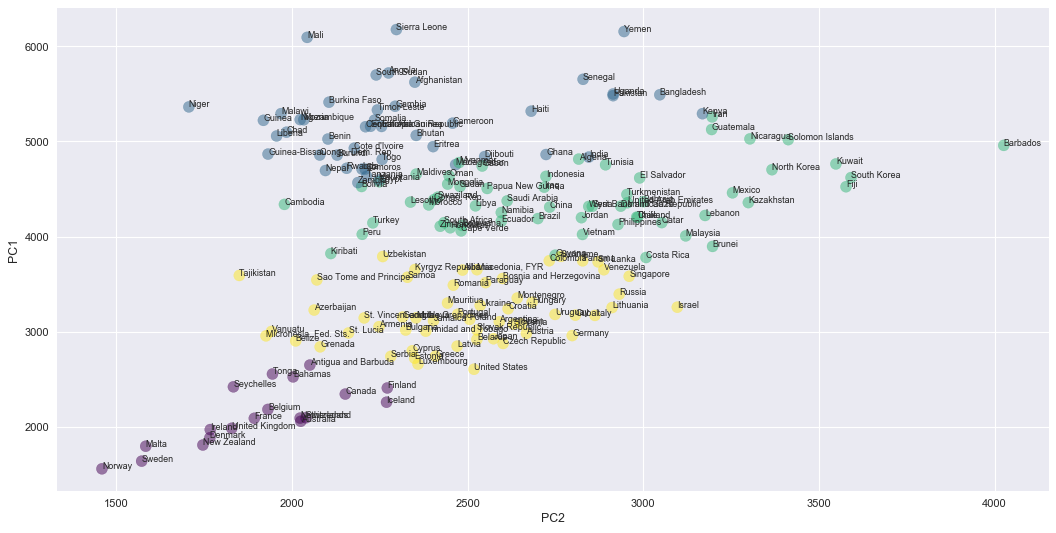

In [25]:
colors = {'D':'red', 'E':'blue', 'F':'green', 'G':'black'}

fig, ax = plt.subplots(figsize=(16, 8), dpi=80)
ax.scatter(child_mortality_PC_df['PC2'], child_mortality_PC_df['PC1'], alpha=0.5,
            s=100, c=child_mortality_PC_df['cluster'], cmap='viridis')

plt.xlabel('PC2')
plt.ylabel('PC1');

for i, country in enumerate(child_mortality_PC_df.index):
    ax.annotate(country, (child_mortality_PC_df.iloc[i].PC2, child_mortality_PC_df.iloc[i].PC1),fontsize=8)

## Investigating trends on the different clusters of countries

In [26]:
child_mortality_df_cluster0= child_mortality_clustered[child_mortality_clustered['cluster']==0]
child_mortality_df_cluster1= child_mortality_clustered[child_mortality_clustered['cluster']==1]
child_mortality_df_cluster2= child_mortality_clustered[child_mortality_clustered['cluster']==2]
child_mortality_df_cluster3= child_mortality_clustered[child_mortality_clustered['cluster']==3]

In [27]:
child_mortality_df_cluster3.head()

,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,cluster
country,,,,,,,,,,,,,,,,,,,,,
Albania,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,...,18.7,17.9,17.3,16.6,16.0,15.5,14.9,14.4,14.0,3
Argentina,402.19,402.19,402.19,402.19,402.19,402.19,402.19,402.19,402.19,402.19,...,15.8,15.4,15.0,14.6,14.2,13.8,13.3,12.9,12.5,3
Armenia,371.20,370.71,370.23,369.75,369.26,368.78,368.30,367.82,367.34,366.86,...,21.1,20.0,19.0,18.0,17.2,16.3,15.5,14.9,14.2,3
Austria,387.32,373.01,359.22,345.95,333.16,320.85,308.99,325.26,315.50,299.15,...,4.6,4.6,4.5,4.4,4.2,4.0,3.9,3.7,3.5,3
Azerbaijan,384.00,383.21,382.43,381.65,380.87,380.09,379.31,378.54,377.76,376.99,...,45.8,43.3,41.0,39.0,37.3,35.7,34.2,32.9,31.7,3


In [28]:
def timeseries_for_clusters_mean(cluster_df):
    
    concat_df = []
    for i in np.unique(cluster_df['cluster']):
        df_cluster= cluster_df[cluster_df['cluster']==i]
        df_cluster.loc['Mean Cluster '+str(i)] = df_cluster.mean() 
        if 'cluster' in df_cluster.columns:
            df_no_cluster = df_cluster.drop(['cluster'], axis=1)
        concat_df.append(pd.DataFrame(df_no_cluster.iloc[-1]))
    
    final_df = pd.concat(concat_df,axis=1)
    
    
    final_df.index = pd.to_datetime(final_df.index.values, format='%Y')    
    ax = final_df.plot(figsize=(16,8), linewidth=5, fontsize=20)
    ax.set_xlabel("Year", fontsize=20)
    ax.set_ylabel("Under 5 child mortality", fontsize=20)
    ax.legend(bbox_to_anchor=(1.1, 1.05))



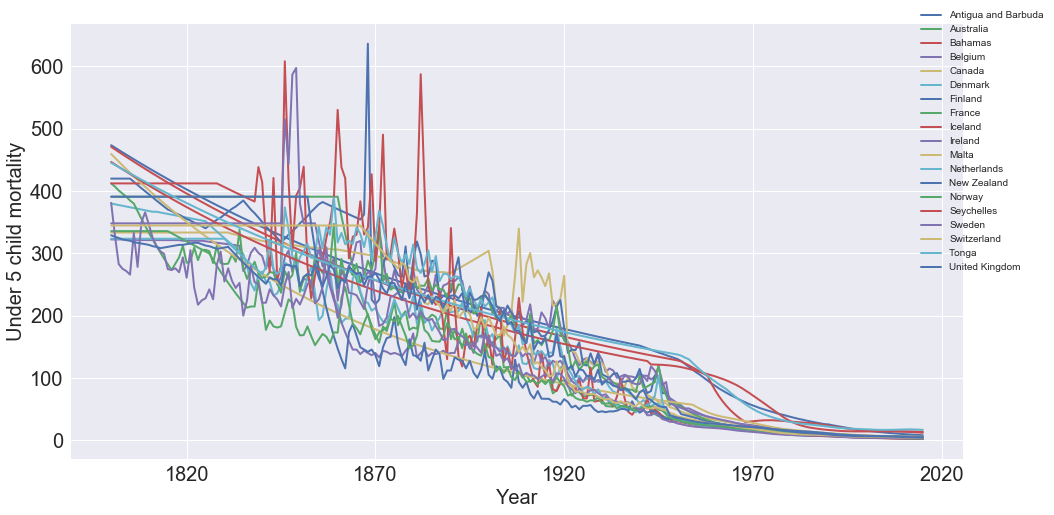

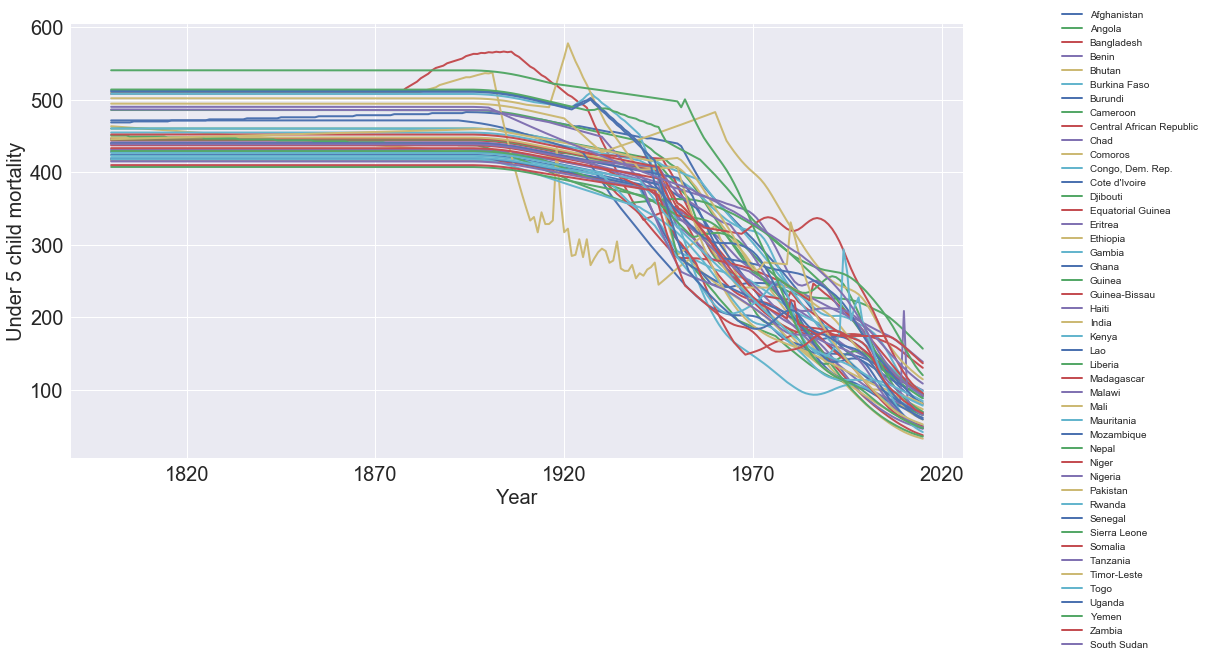

In [29]:
plot_timeseries_df(child_mortality_df_cluster0,2)
plot_timeseries_df(child_mortality_df_cluster1,2)

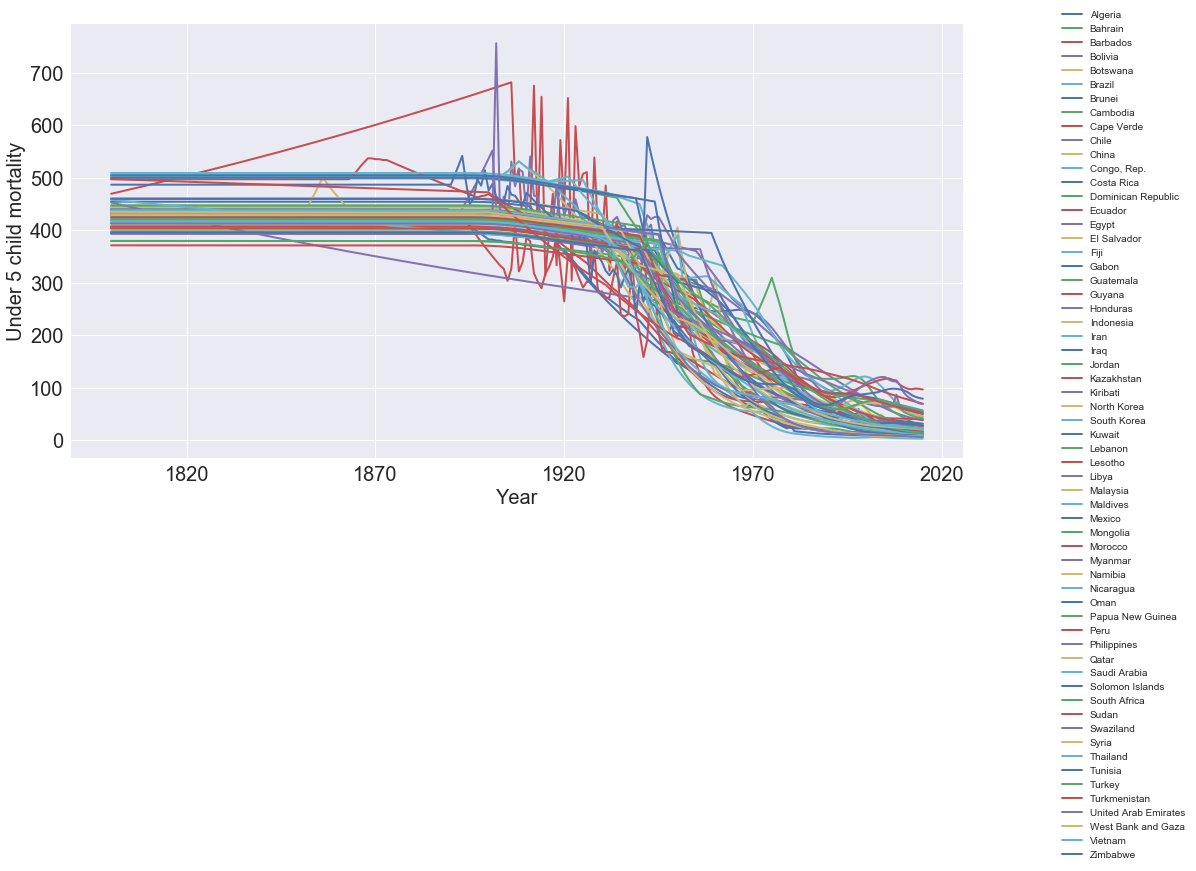

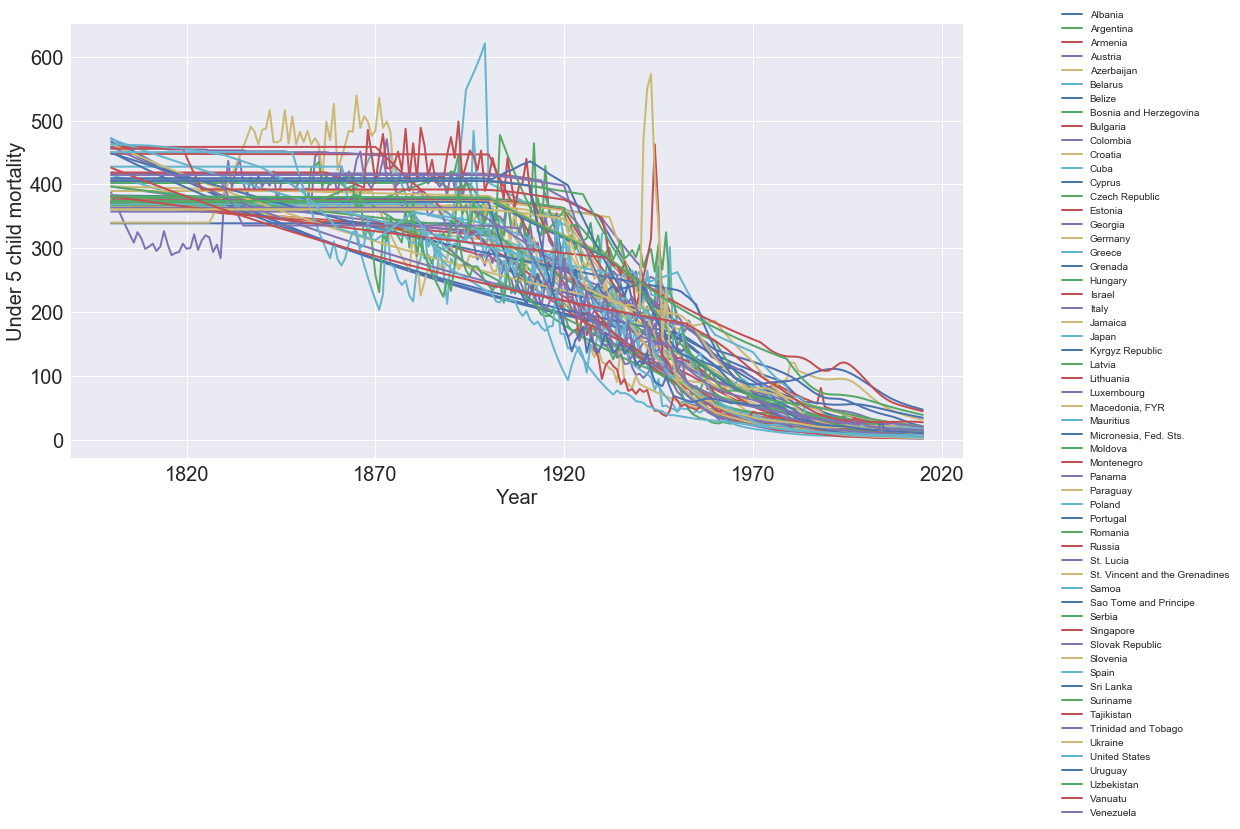

In [30]:
plot_timeseries_df(child_mortality_df_cluster2,2)
plot_timeseries_df(child_mortality_df_cluster3,2)

## Average time series behaivour for each cluster of countries

/Users/camilarangelsmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


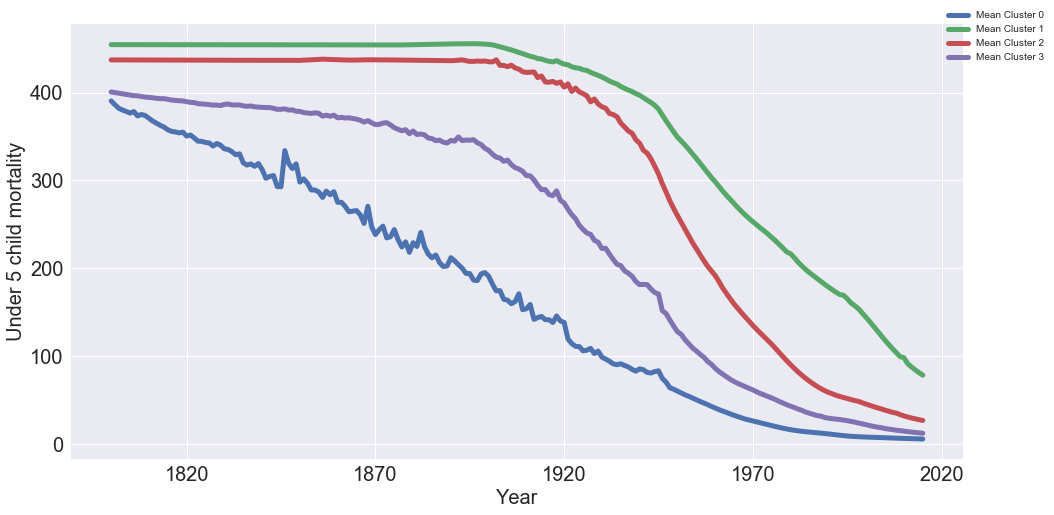

In [31]:
timeseries_for_clusters_mean(child_mortality_clustered)

# Relating different clusters with their GDP per-capita income :

In [32]:
file_path = 'data/gapminder_gdp_per_capita.csv'
gdp_per_capita_df = pd.read_csv(file_path, index_col = 0)

gdp_per_capita_df.shape
gdp_per_capita_df.reset_index(level=0, inplace=True)


In [33]:
gdp_per_capita_df_clean = gdp_per_capita_df.dropna()
gdp_per_capita_df_clean.head()

,GDP per capita,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
1,Afghanistan,603.0,603.0,603.0,603.0,603.0,603.0,603.0,603.0,603.0,...,1173.0,1298.0,1311.0,1548.0,1637.0,1695.0,1893.0,1884.0,1877.0,1925.0
3,Albania,667.0,667.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,...,7476.0,7977.0,8644.0,8994.0,9374.0,9640.0,9811.0,9961.0,10160.0,10620.0
4,Algeria,716.0,716.0,717.0,718.0,719.0,720.0,721.0,722.0,723.0,...,12088.0,12289.0,12314.0,12285.0,12494.0,12606.0,12779.0,12893.0,13179.0,13434.0
6,Andorra,1197.0,1199.0,1201.0,1204.0,1206.0,1208.0,1210.0,1212.0,1215.0,...,42738.0,43442.0,41426.0,41735.0,38982.0,41958.0,41926.0,43735.0,44929.0,46577.0
7,Angola,618.0,620.0,623.0,626.0,628.0,631.0,634.0,637.0,640.0,...,5445.0,6453.0,7103.0,7039.0,7047.0,7094.0,7230.0,7488.0,7546.0,7615.0


In [34]:
child_mortality_clustered.head()

,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,cluster
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,468.58,468.58,468.58,468.58,468.58,468.58,469.98,469.98,469.98,469.98,...,113.2,110.4,107.6,105.0,102.3,99.5,96.7,93.9,91.1,1
Albania,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,...,18.7,17.9,17.3,16.6,16.0,15.5,14.9,14.4,14.0,3
Algeria,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,...,30.7,29.5,28.4,27.4,26.6,25.8,25.2,24.6,24.0,2
Angola,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,...,196.4,192.0,187.3,182.5,177.3,172.2,167.1,162.2,156.9,1
Antigua and Barbuda,473.60,469.77,465.97,462.20,458.47,454.76,451.08,447.43,443.82,440.23,...,11.3,10.9,10.4,9.9,9.5,9.1,8.7,8.4,8.1,0


In [35]:
gdp_list = []
for i in range(child_mortality_clustered.shape[0]):
    
    name =  child_mortality_clustered.index[i]
    try:    
        gdp = float(gdp_per_capita_df_clean[gdp_per_capita_df_clean['GDP per capita']==name]['2015'])
    except Exception:
        gdp = np.nan
    
    gdp_list.append(gdp)
 
child_mortality_clustered_gdp = child_mortality_clustered.copy()
child_mortality_clustered_gdp['GDP']= gdp_list

In [36]:
child_mortality_clustered_gdp = child_mortality_clustered_gdp.dropna()
child_mortality_clustered_gdp.head()

,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2008,2009,2010,2011,2012,2013,2014,2015,cluster,GDP
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,468.58,468.58,468.58,468.58,468.58,468.58,469.98,469.98,469.98,469.98,...,110.4,107.6,105.0,102.3,99.5,96.7,93.9,91.1,1,1925.0
Albania,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,...,17.9,17.3,16.6,16.0,15.5,14.9,14.4,14.0,3,10620.0
Algeria,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,...,29.5,28.4,27.4,26.6,25.8,25.2,24.6,24.0,2,13434.0
Angola,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,...,192.0,187.3,182.5,177.3,172.2,167.1,162.2,156.9,1,7615.0
Antigua and Barbuda,473.60,469.77,465.97,462.20,458.47,454.76,451.08,447.43,443.82,440.23,...,10.9,10.4,9.9,9.5,9.1,8.7,8.4,8.1,0,21049.0


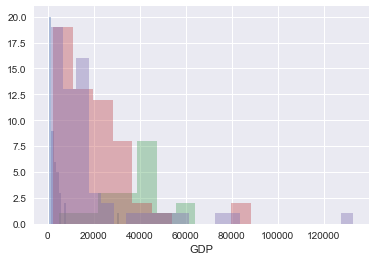

In [37]:
sb.distplot(child_mortality_clustered_gdp[child_mortality_clustered_gdp['cluster']==1]['GDP'],kde=False);
sb.distplot(child_mortality_clustered_gdp[child_mortality_clustered_gdp['cluster']==0]['GDP'],kde=False);
sb.distplot(child_mortality_clustered_gdp[child_mortality_clustered_gdp['cluster']==3]['GDP'],kde=False);
sb.distplot(child_mortality_clustered_gdp[child_mortality_clustered_gdp['cluster']==2]['GDP'],kde=False);



In [38]:
print child_mortality_clustered_gdp[child_mortality_clustered_gdp['cluster']==0]['GDP'].mean()
print child_mortality_clustered_gdp[child_mortality_clustered_gdp['cluster']==0].index

38260.0526316
Index([u'Antigua and Barbuda', u'Australia', u'Bahamas', u'Belgium', u'Canada',
       u'Denmark', u'Finland', u'France', u'Iceland', u'Ireland', u'Malta',
       u'Netherlands', u'New Zealand', u'Norway', u'Seychelles', u'Sweden',
       u'Switzerland', u'Tonga', u'United Kingdom'],
      dtype='object', name=u'country')


In [39]:
print child_mortality_clustered_gdp[child_mortality_clustered_gdp['cluster']==1]['GDP'].mean()
print child_mortality_clustered_gdp[child_mortality_clustered_gdp['cluster']==1].index

3179.60869565
Index([u'Afghanistan', u'Angola', u'Bangladesh', u'Benin', u'Bhutan',
       u'Burkina Faso', u'Burundi', u'Cameroon', u'Central African Republic',
       u'Chad', u'Comoros', u'Congo, Dem. Rep.', u'Cote d'Ivoire', u'Djibouti',
       u'Equatorial Guinea', u'Eritrea', u'Ethiopia', u'Gambia', u'Ghana',
       u'Guinea', u'Guinea-Bissau', u'Haiti', u'India', u'Kenya', u'Lao',
       u'Liberia', u'Madagascar', u'Malawi', u'Mali', u'Mauritania',
       u'Mozambique', u'Nepal', u'Niger', u'Nigeria', u'Pakistan', u'Rwanda',
       u'Senegal', u'Sierra Leone', u'Somalia', u'Tanzania', u'Timor-Leste',
       u'Togo', u'Uganda', u'Yemen', u'Zambia', u'South Sudan'],
      dtype='object', name=u'country')


In [40]:
print child_mortality_clustered_gdp[child_mortality_clustered_gdp['cluster']==2]['GDP'].mean()
print child_mortality_clustered_gdp[child_mortality_clustered_gdp['cluster']==2].index

17709.852459
Index([u'Algeria', u'Bahrain', u'Barbados', u'Bolivia', u'Botswana', u'Brazil',
       u'Brunei', u'Cambodia', u'Cape Verde', u'Chile', u'China',
       u'Congo, Rep.', u'Costa Rica', u'Dominican Republic', u'Ecuador',
       u'Egypt', u'El Salvador', u'Fiji', u'Gabon', u'Guatemala', u'Guyana',
       u'Honduras', u'Indonesia', u'Iran', u'Iraq', u'Jordan', u'Kazakhstan',
       u'Kiribati', u'North Korea', u'South Korea', u'Kuwait', u'Lebanon',
       u'Lesotho', u'Libya', u'Malaysia', u'Maldives', u'Mexico', u'Mongolia',
       u'Morocco', u'Myanmar', u'Namibia', u'Nicaragua', u'Oman',
       u'Papua New Guinea', u'Peru', u'Philippines', u'Qatar', u'Saudi Arabia',
       u'Solomon Islands', u'South Africa', u'Sudan', u'Swaziland', u'Syria',
       u'Thailand', u'Tunisia', u'Turkey', u'Turkmenistan',
       u'United Arab Emirates', u'West Bank and Gaza', u'Vietnam',
       u'Zimbabwe'],
      dtype='object', name=u'country')


In [41]:
print child_mortality_clustered_gdp[child_mortality_clustered_gdp['cluster']==3]['GDP'].mean()
print child_mortality_clustered_gdp[child_mortality_clustered_gdp['cluster']==3].index

20840.7719298
Index([u'Albania', u'Argentina', u'Armenia', u'Austria', u'Azerbaijan',
       u'Belarus', u'Belize', u'Bosnia and Herzegovina', u'Bulgaria',
       u'Colombia', u'Cuba', u'Cyprus', u'Czech Republic', u'Estonia',
       u'Georgia', u'Germany', u'Greece', u'Grenada', u'Hungary', u'Israel',
       u'Italy', u'Jamaica', u'Japan', u'Kyrgyz Republic', u'Latvia',
       u'Lithuania', u'Luxembourg', u'Macedonia, FYR', u'Mauritius',
       u'Micronesia, Fed. Sts.', u'Moldova', u'Montenegro', u'Panama',
       u'Paraguay', u'Poland', u'Portugal', u'Romania', u'Russia',
       u'St. Lucia', u'St. Vincent and the Grenadines', u'Samoa',
       u'Sao Tome and Principe', u'Serbia', u'Singapore', u'Slovak Republic',
       u'Slovenia', u'Spain', u'Sri Lanka', u'Suriname', u'Tajikistan',
       u'Trinidad and Tobago', u'Ukraine', u'United States', u'Uruguay',
       u'Uzbekistan', u'Vanuatu', u'Venezuela'],
      dtype='object', name=u'country')


In [42]:
#things to do:
#write down text about analysis, well writen to be ready for the presentation
